In [12]:
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical

In [2]:
def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=32, max_value=1024, step=32),
                    activation='relu', input_shape=(3072,)))
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int(f'units_{i+2}', min_value=32, max_value=1024, step=32), 
                        activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [5]:
data = np.load('data.npy')
labels = np.load('labels.npy')
data = data.astype('float32') / 255.0
data = data.reshape(data.shape[0],-1)
labels = LabelBinarizer().fit_transform(labels)

In [15]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
test_batch = unpickle('test_batch')
test_data = test_batch[b'data']
test_labels = test_batch[b'labels']
test_data = np.array(test_data)
test_labels = np.array(test_labels)
test_data = test_data.astype('float32') / 255.0
test_data = test_data.reshape(test_data.shape[0], -1)
print("Test Data shape:", test_data.shape)
print("Test Labels shape:", test_labels.shape)

Test Data shape: (10000, 3072)
Test Labels shape: (10000,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [26]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

In [8]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='tuning_ffnw_4',
    overwrite=True
)
tuner.search_space_summary()
tuner.search(X_train, y_train, epochs=35, validation_data=(X_test, y_test), verbose=1)

Trial 10 Complete [00h 10m 47s]
val_accuracy: 0.5422000288963318

Best val_accuracy So Far: 0.5486000180244446
Total elapsed time: 03h 29m 56s


Epoch 1/35
1250/1250 [==============================] - 21s 17ms/step - loss: 1.8089 - accuracy: 0.3486 - val_loss: 1.6765 - val_accuracy: 0.3984
Epoch 2/35
1250/1250 [==============================] - 20s 16ms/step - loss: 1.6126 - accuracy: 0.4244 - val_loss: 1.5839 - val_accuracy: 0.4293
Epoch 3/35
1250/1250 [==============================] - 21s 17ms/step - loss: 1.5232 - accuracy: 0.4558 - val_loss: 1.5484 - val_accuracy: 0.4421
Epoch 4/35
1250/1250 [==============================] - 21s 17ms/step - loss: 1.4519 - accuracy: 0.4834 - val_loss: 1.5002 - val_accuracy: 0.4642
Epoch 5/35
1250/1250 [==============================] - 22s 18ms/step - loss: 1.3982 - accuracy: 0.5036 - val_loss: 1.5852 - val_accuracy: 0.4390
Epoch 6/35
1250/1250 [==============================] - 21s 17ms/step - loss: 1.3459 - accuracy: 0.5213 - val_loss: 1.4653 - val_accuracy: 0.4735
Epoch 7/35
1250/1250 [==============================] - 20s 16ms/step - loss: 1.2950 - accuracy: 0.5374 - val_loss: 1.4413 -

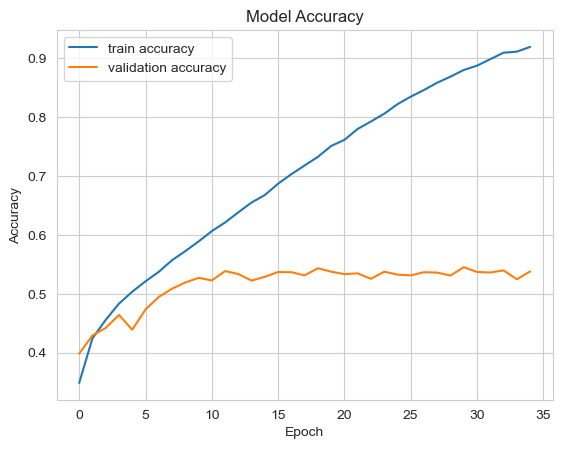

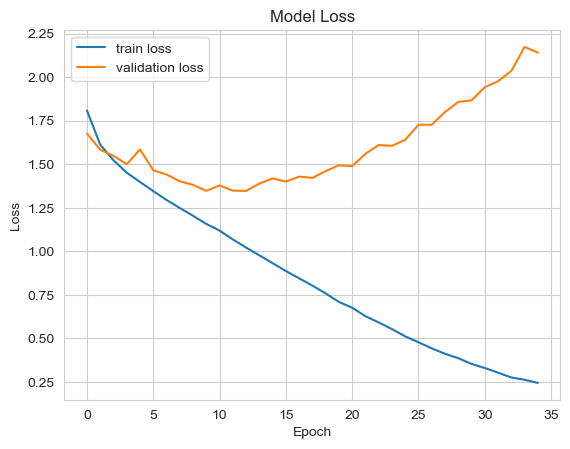

In [9]:
best_trials = tuner.oracle.get_best_trials()
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=35, validation_data=(X_test, y_test))
# Evaluate the model
val_loss, val_accuracy = model.evaluate(X_test, y_test)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
plt.figure()
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [17]:
test_loss, test_accuracy = model.evaluate(test_data, to_categorical(test_labels))
print(test_loss, test_accuracy)
print("The hyperparameter search is complete.")
print(f"Optimal number of units in the first densely connected layer: {best_hps.get('units_1')}")
print(f"Optimal number of hidden layers: {best_hps.get('num_layers')}")
for i in range(best_hps.get('num_layers')):
    print(f"Optimal number of units in layer {i+2}: {best_hps.get(f'units_{i+2}')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")

313/313 [==============================] - 2s 8ms/step - loss: 2.1211 - accuracy: 0.5349
2.12113094329834 0.5349000096321106
The hyperparameter search is complete.
Optimal number of units in the first densely connected layer: 1024
Optimal number of hidden layers: 2
Optimal number of units in layer 2: 832
Optimal number of units in layer 3: 832
Optimal learning rate: 0.0001


learning curve on the amount of data included

In [11]:
def train_with_different_data_size(size):
    subset_X_train = X_train[:size]
    subset_y_train = y_train[:size]
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(3072,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(subset_X_train, subset_y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
    return history

In [12]:
data_sizes = [10000, 20000, 30000, 40000]
histories_data_size = {}
for size in data_sizes:
    histories_data_size[size] = train_with_different_data_size(size)

In [13]:
plt.figure()
for size, history in histories_data_size.items():
    plt.plot(history.history['val_accuracy'], label=f'size={size}')
plt.title('accuracy vs data size')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

learning curve on learning rate

In [43]:
def train_with_different_lr(lr):
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(3072,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=0)
    return history

In [44]:
learning_rates = [1e-2, 1e-3, 1e-4]
histories = {}
for lr in learning_rates:
    histories[lr] = train_with_different_lr(lr)

In [45]:
plt.figure()
for lr, history in histories.items():
    plt.plot(history.history['val_accuracy'], label=f'lr={lr}')
plt.title('accracy vs learning rate')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()